In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import numpy as np
import scipy.signal as sig
import keras
import h5py
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model
from keras.models import load_model
from keras import regularizers
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path

Using TensorFlow backend.


### Load data and Preprocessing 


In [2]:
# fix random seed for reproducibility
np.random.seed(8)

# Load data and exclude nan value
#data = np.genfromtxt('H1O1O2_GPR_earthquakes.txt')
data = np.genfromtxt('IRISwest.txt')

In [3]:
#mostly for IRIS data
#####maybe if we cut out the IRIS P waves we can get better results## 
#going to chooose 6000 

#eqgpstime = data[:,1]
#peakgpstime = data[:,17]
#arrivaltime = np.subtract(peakgpstime,eqgpstime)
#distance = data[:,13]
#Velocity = np.divide(distance, arrivaltime)
#pwaveomit = 6000
#Velocity1 = Velocity[Velocity<6000]
##data = data[Velocity<6000]
print (len(data))

245923


## To exclude non-land points 

In [4]:
#This cell excludes Earthquakes not on land
#Warning: takes a while to run.

#eq_lat2 = data[:,11]
#eq_lon2 = data[:,12]
#map1 = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50, resolution='h')
#lats = eq_lat2  #[:100]                                                                                                        \
                                                                                                                                
#lons = eq_lon2
#x, y = map1(lons, lats)
#locations = np.c_[x, y]
#polygons = [Path(p.boundary) for p in map1.landpolygons]
#result = np.zeros(len(locations), dtype=bool)
#for polygon in polygons:
 #   result += np.array(polygon.contains_points(locations))

#eq_lat1=lats[result]
#eq_lon1=lons[result]
#print (len(data))
#print (result)
#data =data[result]
print (len(data))



245923


In [5]:

# Extract X and y and divide into train, val, and test set
X = data[:, [2, 11, 12, 13, 14, 15]]#iris
#X = data[:, [1, 10, 11, 12, 13, 14]] #L10102, H10102, V10102

y = np.log10(data[:, 18]) #iris 
#y = np.log10(data[:, 25])  #L10102, H10102, V10102

#cutting out earthquakes with a ground velocity less 1e-6
mask = y > -6.0   

y = y[mask]
X = X[mask]

# Normalizing
X -= np.mean(X, axis=0) 
X /= np.std(X, axis=0)

mean_y = np.mean(y, axis=0)
stdv_y = np.std(y, axis=0)
y = (y-mean_y)/stdv_y

# Shuffle and divide into train and val set
mask = np.random.permutation(X.shape[0]) #(does this work with seed?)
X = X[mask]
y = y[mask]
#distance = distance[mask]
                
tfrac = int(0*y.size) #In training 0.8 but here testing against all data
#X_train = X[:tfrac]
#y_train = y[:tfrac]
X_val = X[tfrac:]
y_val = y[tfrac:]
#distance_val=distance[mask]

#print('X_train shape: {}'.format(X_train.shape))
#print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

X_val shape: (235305, 6)
y_val shape: (235305,)


## Load Model

In [6]:
model = load_model('livgv1.hdf5')


## Predict 

In [7]:
y_pred = model.predict(X_val) 
# Inverse-normalize
y_val = y_val*stdv_y + mean_y
y_pred = y_pred*stdv_y + mean_y

(235305,)
(235305,)


/anaconda3/envs/ligo/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


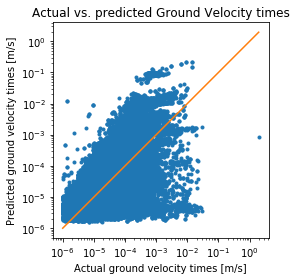

In [8]:
print(y_val.shape)
y_pred = y_pred.flatten()
print(y_pred.shape)
absy_val = abs(y_val)
absy_pred = abs(y_pred)

#taking antilog so we can see what we are used too 
antiy_val = 10**y_val
antiy_pred = 10**y_pred

v_min = min(np.min(antiy_val), np.min(antiy_pred))
v_max = max(np.max(antiy_val), np.max(antiy_pred))
x = np.linspace(v_min, v_max, 1000)

fig, ax = plt.subplots()

ax.loglog(antiy_val, antiy_pred, '.')
ax.plot(x, x)

ax.set(ylabel='Predicted ground velocity times [m/s]', xlabel='Actual ground velocity times [m/s]',title = 'Actual vs. predicted Ground Velocity times' )
ax.set(adjustable='box-forced', aspect='equal')

fig.tight_layout()

plt.savefig('livoniw1.png', dpi =300,bbox_inches='tight')




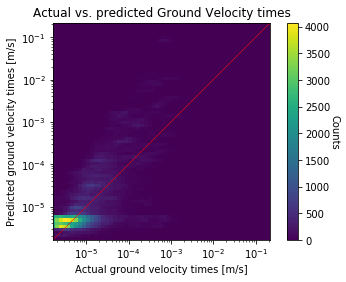

In [9]:
x = np.linspace(v_min, v_max, 1000)
fig2, ax, = plt.subplots()
x_bins = np.logspace(np.log10(antiy_val.min()), np.log10(antiy_val.max()),np.sqrt(5000)) #12279
y_bins = np.logspace(np.log10(antiy_pred.min()), np.log10(antiy_pred.max()),np.sqrt(5000))
H, xedges, yedges = np.histogram2d(antiy_val, antiy_pred, bins=[x_bins,y_bins])
#ax2 = fig.add_subplot(212)
h = ax.pcolormesh(xedges, yedges, H.T)
#ax.set_aspect('equal')
#ax.set(adjustable='box-forced', aspect='equal')
#a2.imshow(img, origin='lower', extent=extent, aspect='auto')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
#ax.set(ylabel='Predicted arrival times [s]', xlabel='Actual Arrival times [m/s]',title = 'Actual vs. predicted arrival times')
ax.set(ylabel='Predicted ground velocity times [m/s]', xlabel='Actual ground velocity times [m/s]',title = 'Actual vs. predicted Ground Velocity times')



cbar = plt.colorbar(h, ax=ax)
ax.plot(x, x, c='r',linewidth=.5)
#ax.set_ylim([0, 10e-2])
#ax.set_xlim([0, 10e-2])
#ax.set_aspect('equal')
#cbar =plt.colorbar()
#cbar.ax.set_ylabel('Counts')
cbar.set_label('Counts', rotation=270,labelpad=9)

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('livoniwdensity1.png', dpi =300,bbox_inches='tight')

plt.show()

(235305,)


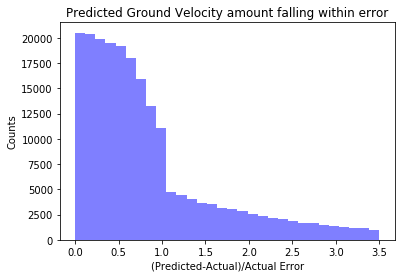

In [10]:
z = np.array(abs((antiy_val -antiy_pred)/antiy_val))
print(z.shape)
#print (np.average(z))
plt.hist(z, bins=30,range =[0,3.5], facecolor='blue', alpha=0.5)
plt.xlabel('(Predicted-Actual)/Actual Error')
plt.ylabel('Counts')
plt.title('Predicted Ground Velocity amount falling within error')
plt.savefig('livoniwhist1.png', dpi =300,bbox_inches='tight')
plt.show()